# Sementic Segmentation

In [9]:
import scipy
import scipy.misc
import tensorflow as tf

## Check GPUs

In [10]:
from tensorflow.python.client import device_lib

def print_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

print_available_gpus()

['/device:GPU:0']


In [11]:
import re
import random
import numpy as np
import os.path
import shutil
import zipfile
import time
import tensorflow as tf
from glob import glob
from urllib.request import urlretrieve
from tqdm import tqdm
import helper

## Method to generate batch of data

In [12]:
def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                scipy.misc.imread(image_file)
                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

# Explore the dataset

Image shape (1, 160, 576, 3)
Labels shape (1, 160, 576, 2)
Mask shape (1, 160, 576)


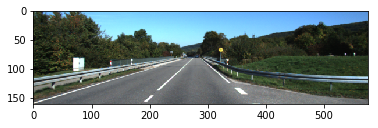

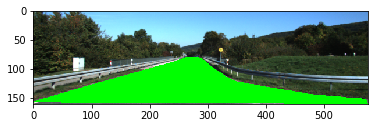

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def explore_dataset():
    get_batches_fn = gen_batch_function('/home/thibault/datasets/data_road/training', (160, 576))
    for images, labels in get_batches_fn(1):
        print("Image shape", images.shape)
        print("Labels shape", labels.shape)
        mask = labels[:,:,:,0]==0
        print("Mask shape", mask.shape)
        images_overlay = np.copy(images)
        images_overlay[mask==True] = [0, 255, 0]
         
        plt.imshow(images[0])
        plt.show()
        plt.imshow(images_overlay[0])
        plt.show()
        break
        
explore_dataset()

## Load VGG

In [14]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    inpt = graph.get_tensor_by_name(vgg_input_tensor_name)
    kp = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    l3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    l4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    l7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    print(l3, l4, l7)
    
    return inpt, kp, l3, l4, l7

## Create the layers

In [15]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output (linear) and The tensor for the softmax output
    """
    with tf.variable_scope("fcn", reuse=tf.AUTO_REUSE):
        layer7conv1x1 = tf.layers.conv2d(
            vgg_layer7_out, num_classes, 1, strides=(1,1), padding='same', 
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
            kernel_initializer= tf.random_normal_initializer(stddev=0.01)
        )
        layer4conv1x1 = tf.layers.conv2d(
            vgg_layer4_out, num_classes, 1, strides=(1,1), padding='same',
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
            kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        )
        
        layer3conv1x1 = tf.layers.conv2d(
            vgg_layer3_out, num_classes, 1, strides=(1,1), padding='same', 
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
            kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        )

        t1 = tf.layers.conv2d_transpose(
            layer7conv1x1, num_classes, 4, strides=(2,2), padding='same',
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
            kernel_initializer= tf.random_normal_initializer(stddev=0.01)
        )
        
        t1 = tf.add(t1, layer4conv1x1)

        t2 = tf.layers.conv2d_transpose(
            t1, num_classes, 4, strides=(2,2), padding='same',
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
            kernel_initializer= tf.random_normal_initializer(stddev=0.01)
        )
        
        t2 = tf.add(t2, layer3conv1x1)

        t3 = tf.layers.conv2d_transpose(
            t2, num_classes, 16, strides=(8,8), padding='same',
            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
             kernel_initializer= tf.random_normal_initializer(stddev=0.01)
        )

        return t3, tf.nn.softmax(t3)

## Optimize model

In [16]:
def optimize(logits, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    with tf.variable_scope("fcn", reuse=tf.AUTO_REUSE):
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label))
        cross_entropy_loss += tf.reduce_mean(tf.losses.get_regularization_losses(scope="fcn"))
        
    with tf.variable_scope("fcn", reuse=tf.AUTO_REUSE):
        optimizer = tf.train.AdamOptimizer(0.001)
        train_op = optimizer.minimize(cross_entropy_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='fcn'))

    return logits, train_op, cross_entropy_loss

In [17]:
tf.reset_default_graph()
sess = tf.Session()

vgg_graph = load_vgg(sess, "/home/thibault/datasets/vgg")

vgg_graph = {
    "input": vgg_graph[0],
    "keep_prob": vgg_graph[1],
    "layer_3": vgg_graph[2],
    "layer_4": vgg_graph[3],
    "layer_5": vgg_graph[4]
}

print("VGG Loaded")

INFO:tensorflow:Restoring parameters from /home/thibault/datasets/vgg/variables/variables
Tensor("layer3_out:0", shape=(?, ?, ?, 256), dtype=float32) Tensor("layer4_out:0", shape=(?, ?, ?, 512), dtype=float32) Tensor("layer7_out:0", shape=(?, ?, ?, 4096), dtype=float32)
VGG Loaded


## Init Model

In [18]:
def init_model(sess, vgg_graph):
    num_classes = 2
    learning_rate = 0.0001

    correct_label = tf.placeholder(tf.float32, shape=(None, 160, 576, num_classes))

    # TODO: Build NN using load_vgg, layers, and optimize function
    logits, softmax = layers(vgg_graph["layer_3"], vgg_graph["layer_4"], vgg_graph["layer_5"], num_classes)
    
    logits, train_op, cross_entropy_loss = optimize(logits, correct_label, learning_rate, num_classes)

    sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='fcn')))

    return logits, softmax, train_op, cross_entropy_loss, correct_label
            
logits, softmax, train_op, cross_entropy_loss, correct_label = init_model(sess, vgg_graph)

In [19]:
def train(vgg_graph, logits, softmax, train_op, cross_entropy_loss, correct_label):
    image_shape = (160, 576)
    batch_size = 32
    epochs = 40
        
    get_batches_fn_training = gen_batch_function('/home/thibault/datasets/data_road/training', (160, 576))
    get_batches_fn_validation = gen_batch_function('/home/thibault/datasets/data_road/testing', (160, 576))
    
    validation_gen = get_batches_fn_validation(batch_size) 
    
    for epoch in range(epochs):
        
        for images, labels in get_batches_fn_training(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict={
                vgg_graph["input"]: images,
                vgg_graph["keep_prob"]: 0.5,
                correct_label: labels
            })

        print("[Epoch:%s] Training loss : %s" % (epoch, loss))

train(vgg_graph, logits, softmax, train_op, cross_entropy_loss, correct_label)

[Epoch:0] Training loss : 0.39692456
[Epoch:1] Training loss : 0.31599987
[Epoch:2] Training loss : 0.23554383
[Epoch:3] Training loss : 0.17712878
[Epoch:4] Training loss : 0.20454858
[Epoch:5] Training loss : 0.18403697
[Epoch:6] Training loss : 0.19216044
[Epoch:7] Training loss : 0.24472925
[Epoch:8] Training loss : 0.08681358
[Epoch:9] Training loss : 0.11610311
[Epoch:10] Training loss : 0.18183403
[Epoch:11] Training loss : 0.11574307
[Epoch:12] Training loss : 0.13496493
[Epoch:13] Training loss : 0.12743457
[Epoch:14] Training loss : 0.15588588
[Epoch:15] Training loss : 0.10476178
[Epoch:16] Training loss : 0.1603176
[Epoch:17] Training loss : 0.08201979
[Epoch:18] Training loss : 0.09150442
[Epoch:19] Training loss : 0.19246605
[Epoch:20] Training loss : 0.07891282
[Epoch:21] Training loss : 0.13709903
[Epoch:22] Training loss : 0.0738078
[Epoch:23] Training loss : 0.07316267
[Epoch:24] Training loss : 0.15224035
[Epoch:25] Training loss : 0.10654932
[Epoch:26] Training loss

## Quick test on training set

Image shape (1, 160, 576, 3)
Labels shape (1, 160, 576, 2)
Prediction shape (1, 160, 576)
Mask shape (1, 160, 576)
images_overlay_p shape (1, 160, 576, 3)


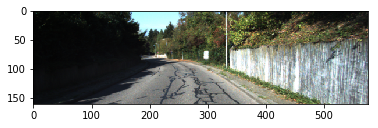

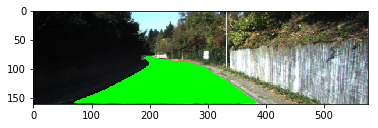

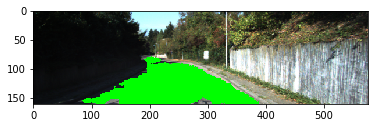

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def quick_test():
    get_batches_fn = gen_batch_function('/home/thibault/datasets/data_road/training', (160, 576))
    for images, labels in get_batches_fn(1):
        print("Image shape", images.shape)
        print("Labels shape", labels.shape)
        mask = labels[:,:,:,0]==0
        
        prediction = sess.run([softmax], feed_dict={
                vgg_graph["input"]: images,
                vgg_graph["keep_prob"]: 1.0,
                correct_label: labels
        })[0]
        prediction = prediction.argmax(axis=3)
        
        print("Prediction shape", prediction.shape)
        
        print("Mask shape", mask.shape)
        images_overlay = np.copy(images)
        images_overlay[mask==True] = [0, 255, 0]

        mask2 = prediction #[:,:,:,0]==0
        images_overlay_p = np.copy(images)
        images_overlay_p[mask2==True] = [0, 255, 0]
        
        print("images_overlay_p shape", images_overlay_p.shape)
        
        plt.imshow(images[0])
        plt.show()
        plt.imshow(images_overlay[0])
        plt.show()
        plt.imshow(images_overlay_p[0])
        plt.show()
        break
        
quick_test()

## Save model

In [24]:
saver = tf.train.Saver()
save_path = saver.save(sess, "/home/thibault/datasets/sementic_segmentation/model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: /home/thibault/datasets/sementic_segmentation/model.ckpt


## Load pre trained model

In [27]:
tf.reset_default_graph()
sess = tf.Session()

vgg_graph = load_vgg(sess, "/home/thibault/datasets/vgg")

vgg_graph = {
    "input": vgg_graph[0],
    "keep_prob": vgg_graph[1],
    "layer_3": vgg_graph[2],
    "layer_4": vgg_graph[3],
    "layer_5": vgg_graph[4]
}


logits, softmax, train_op, cross_entropy_loss, correct_label = init_model(sess, vgg_graph)


saver = tf.train.Saver()

saver.restore(sess, "/home/thibault/datasets/sementic_segmentation/model.ckpt")

INFO:tensorflow:Restoring parameters from /home/thibault/datasets/vgg/variables/variables
Tensor("layer3_out:0", shape=(?, ?, ?, 256), dtype=float32) Tensor("layer4_out:0", shape=(?, ?, ?, 512), dtype=float32) Tensor("layer7_out:0", shape=(?, ?, ?, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/thibault/datasets/sementic_segmentation/model.ckpt


# Test on the testing set

In [28]:
def gen_test_output(sess, softmax, keep_prob, image_pl, data_folder, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep robability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    for image_file in glob(os.path.join(data_folder, 'image_2', '*.png')):
        print(image_file)
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)

        plt.imshow(image)
        plt.show()

        im_softmax = sess.run([softmax],{
            keep_prob: 1.0, 
            image_pl: [image]
        })[0]

        prediction = im_softmax.argmax(axis=3)[0]
        
        
        images_overlay = np.copy(image)
        images_overlay[prediction==True] = [0, 255, 0]

        plt.imshow(images_overlay)
        plt.show()

        yield os.path.basename(image_file), images_overlay


def save_inference_samples(runs_dir, data_dir, sess, image_shape, softmax, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape)
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)

Training Finished. Saving test images to: /home/thibault/output/1537532478.5431204
/home/thibault/datasets/data_road/testing/image_2/umm_000010.png


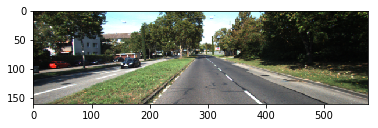

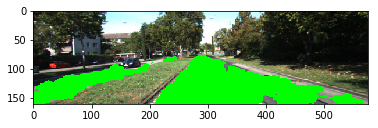

/home/thibault/datasets/data_road/testing/image_2/um_000077.png


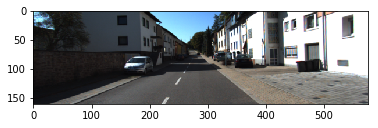

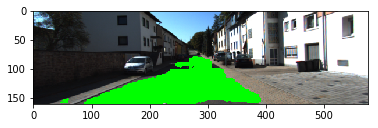

/home/thibault/datasets/data_road/testing/image_2/um_000069.png


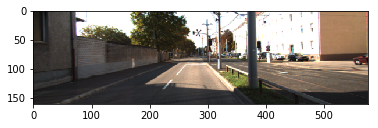

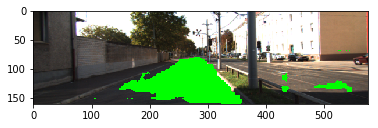

/home/thibault/datasets/data_road/testing/image_2/um_000045.png


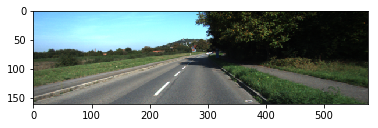

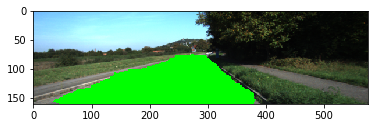

/home/thibault/datasets/data_road/testing/image_2/umm_000008.png


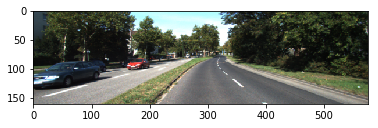

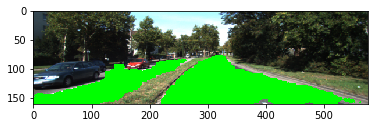

/home/thibault/datasets/data_road/testing/image_2/uu_000027.png


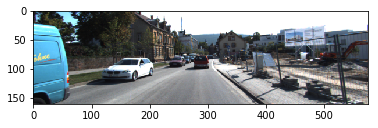

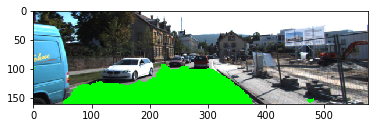

/home/thibault/datasets/data_road/testing/image_2/uu_000017.png


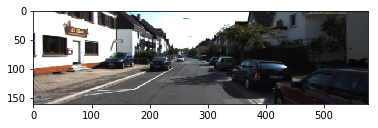

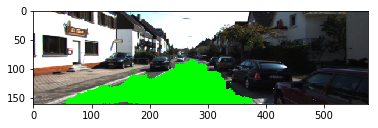

/home/thibault/datasets/data_road/testing/image_2/umm_000023.png


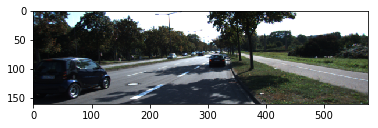

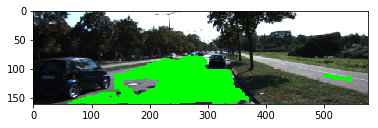

/home/thibault/datasets/data_road/testing/image_2/uu_000092.png


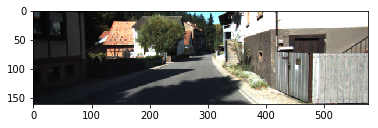

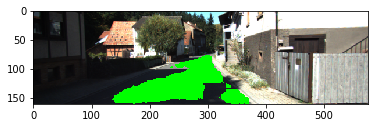

/home/thibault/datasets/data_road/testing/image_2/umm_000089.png


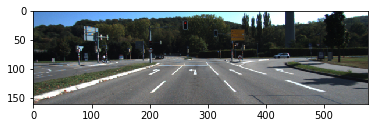

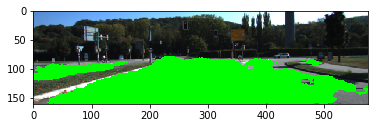

/home/thibault/datasets/data_road/testing/image_2/um_000003.png


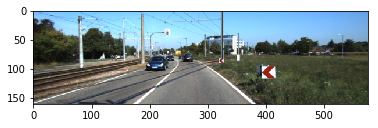

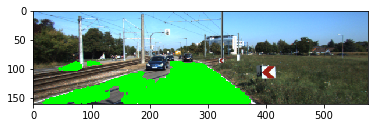

/home/thibault/datasets/data_road/testing/image_2/umm_000088.png


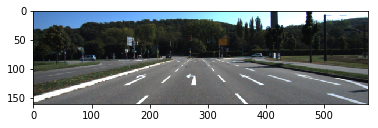

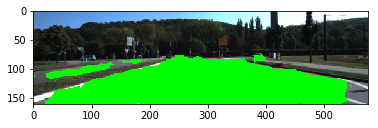

/home/thibault/datasets/data_road/testing/image_2/um_000025.png


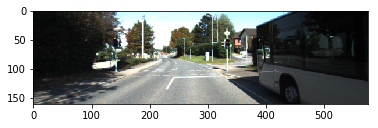

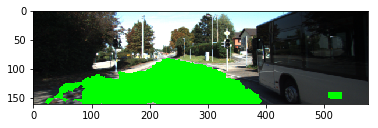

/home/thibault/datasets/data_road/testing/image_2/umm_000085.png


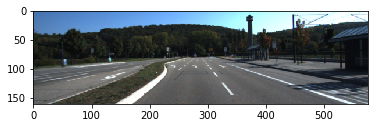

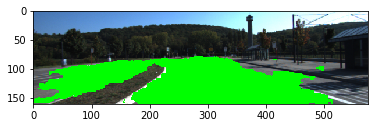

/home/thibault/datasets/data_road/testing/image_2/umm_000044.png


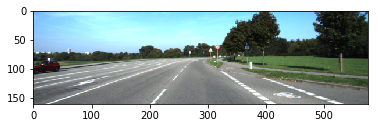

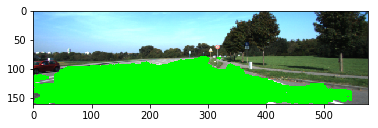

/home/thibault/datasets/data_road/testing/image_2/umm_000083.png


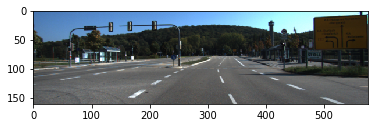

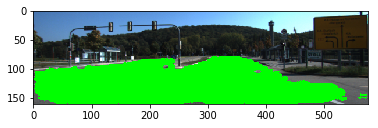

/home/thibault/datasets/data_road/testing/image_2/um_000093.png


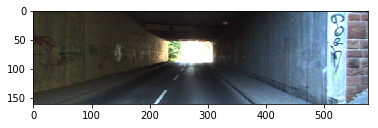

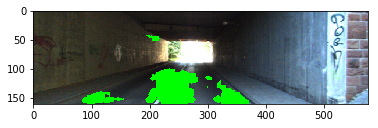

/home/thibault/datasets/data_road/testing/image_2/um_000006.png


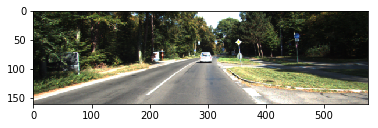

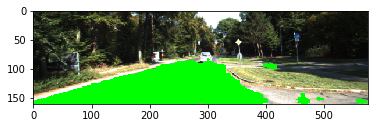

/home/thibault/datasets/data_road/testing/image_2/umm_000007.png


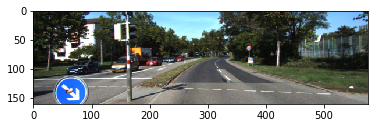

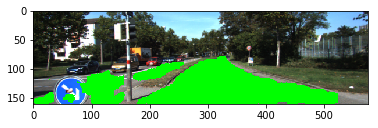

/home/thibault/datasets/data_road/testing/image_2/umm_000075.png


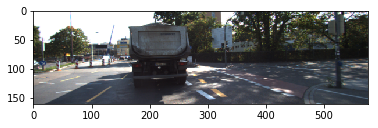

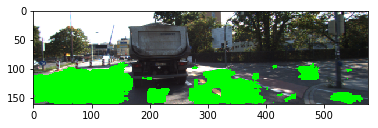

/home/thibault/datasets/data_road/testing/image_2/um_000055.png


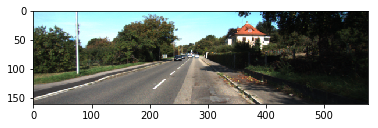

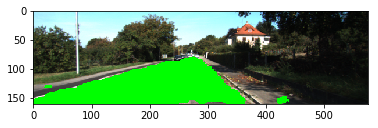

/home/thibault/datasets/data_road/testing/image_2/umm_000018.png


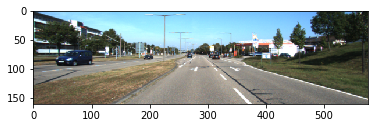

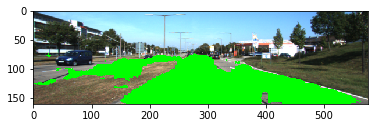

In [ ]:
save_inference_samples("/home/thibault/output/", "/home/thibault/datasets/", sess, (160, 576), softmax, vgg_graph["keep_prob"], vgg_graph["input"])